In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

Loading dataset

In [2]:
dataset_train = pd.read_csv("train.csv")
dataset_test = pd.read_csv("test.csv")

1.Train Dataset - EDA

In [3]:
dataset_train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
dataset_train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


In [5]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [6]:
dataset_train.nunique()

id                  630000
age                      8
gender                   3
course                   7
study_hours            792
class_attendance       617
internet_access          2
sleep_hours             66
sleep_quality            3
study_method             5
facility_rating          3
exam_difficulty          3
exam_score             805
dtype: int64

Visualize the frequency of exam scores

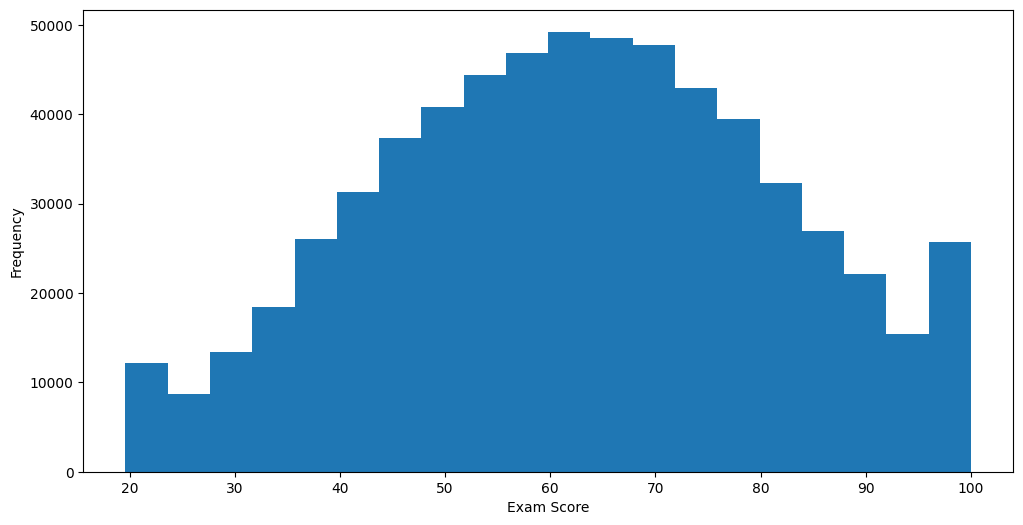

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(dataset_train["exam_score"], bins=20)
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.show()

Analysis of the age column

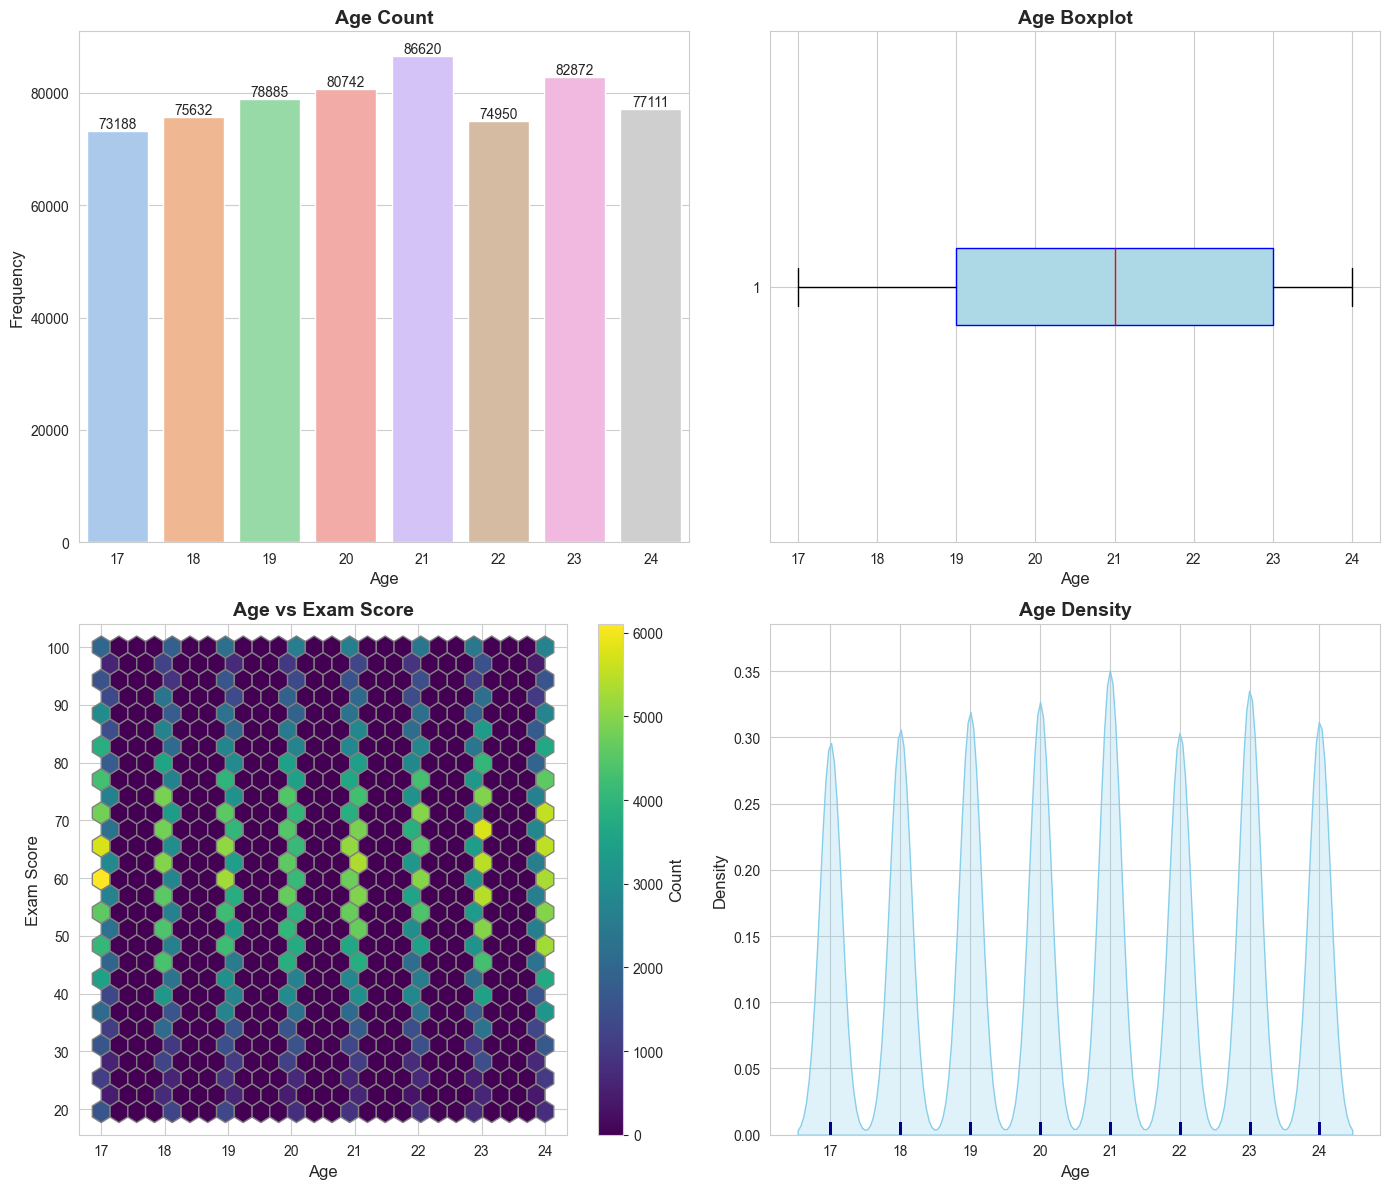

In [8]:
# Set style
sns.set_style("whitegrid")
palette = "pastel"

# Create 2x2 figure
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

# 1 Countplot: Age frequencies
sns.countplot(x="age", data=dataset_train, ax=ax[0], palette=palette)
ax[0].set_title("Age Count", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Age", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)

# Annotate counts
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}',  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)

# 2 Boxplot: Age summary
ax[1].boxplot(dataset_train["age"], vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue'),
              medianprops=dict(color='red'))
ax[1].set_xlabel("Age", fontsize=12)
ax[1].set_title("Age Boxplot", fontsize=14, fontweight='bold')

# 3 Hexbin: Age vs Exam Score
hb = ax[2].hexbin(
    dataset_train["age"],
    dataset_train["exam_score"],
    gridsize=25,
    cmap="viridis",
    edgecolors='grey'
)
cbar = plt.colorbar(hb, ax=ax[2])
cbar.set_label("Count", fontsize=12)
ax[2].set_xlabel("Age", fontsize=12)
ax[2].set_ylabel("Exam Score", fontsize=12)
ax[2].set_title("Age vs Exam Score", fontsize=14, fontweight='bold')

# 4 KDE: Age distribution
sns.kdeplot(dataset_train["age"], ax=ax[3], fill=True, color='skyblue')
sns.rugplot(dataset_train["age"], ax=ax[3], color='darkblue')
ax[3].set_xlabel("Age", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Age Density", fontsize=14, fontweight='bold')

# Layout adjustments
plt.tight_layout()
plt.show()


Analysis of the gender column

In [ ]:
dataset_train['gender'].value_counts()

gender
other     211097
male      210593
female    208310
Name: count, dtype: int64

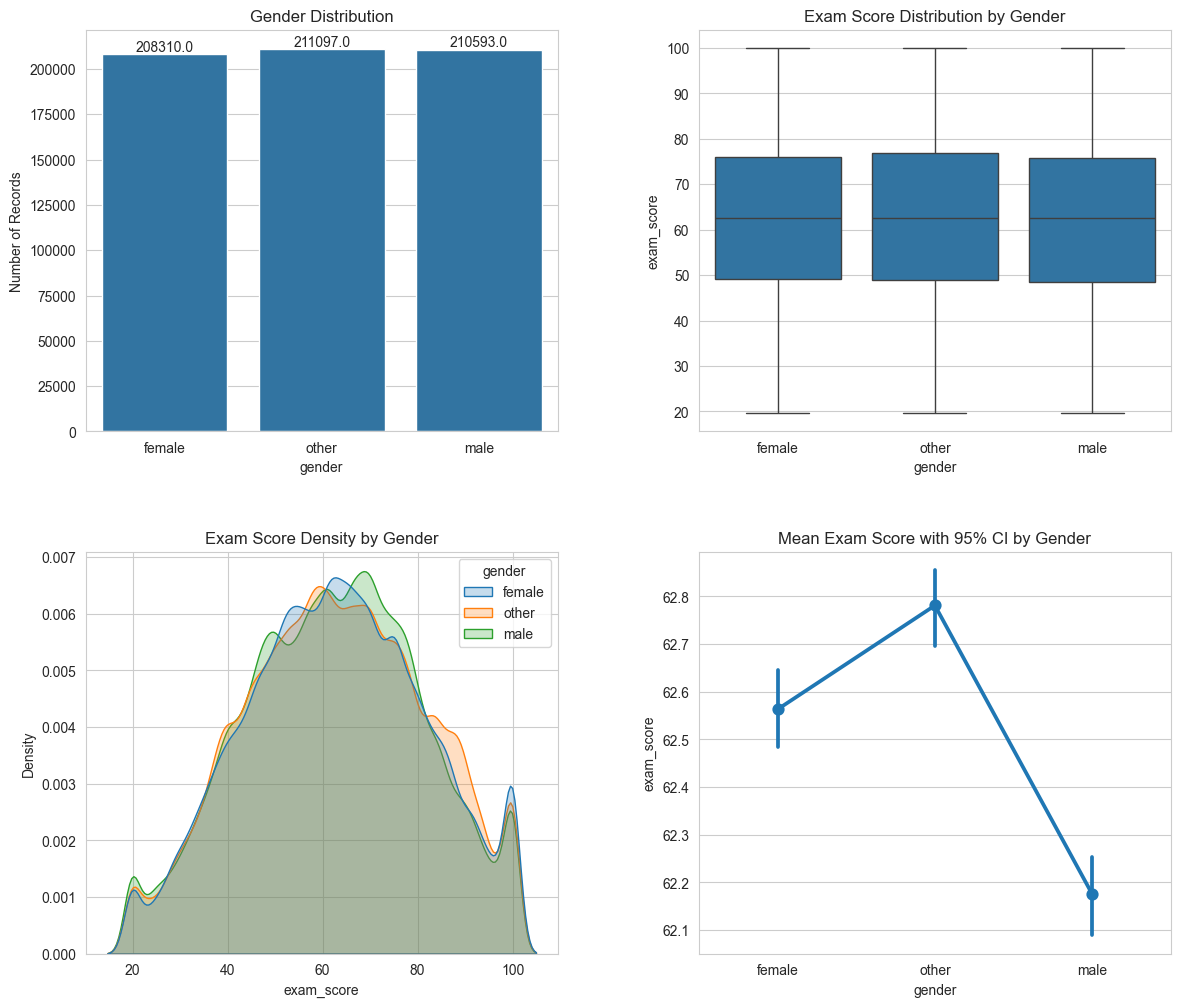

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x='gender', data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')
ax[0].set_title('Gender Distribution')
ax[0].set_ylabel('Number of Records')

sns.boxplot(x='gender', y='exam_score', data=dataset_train, ax=ax[1])
ax[1].set_title('Exam Score Distribution by Gender')

sns.kdeplot(data=dataset_train, x='exam_score', hue='gender', fill=True, ax=ax[2])
ax[2].set_title('Exam Score Density by Gender')

sns.pointplot(x='gender', y='exam_score', data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title('Mean Exam Score with 95% CI by Gender')


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

1.2 Test Dataset - EDA

In [9]:
dataset_test.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [10]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB


In [11]:
dataset_test.describe()

,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000


In [16]:
dataset_test.nunique()

id                  270000
age                      8
gender                   3
course                   7
study_hours            786
class_attendance       604
internet_access          2
sleep_hours             64
sleep_quality            3
study_method             5
facility_rating          3
exam_difficulty          3
dtype: int64

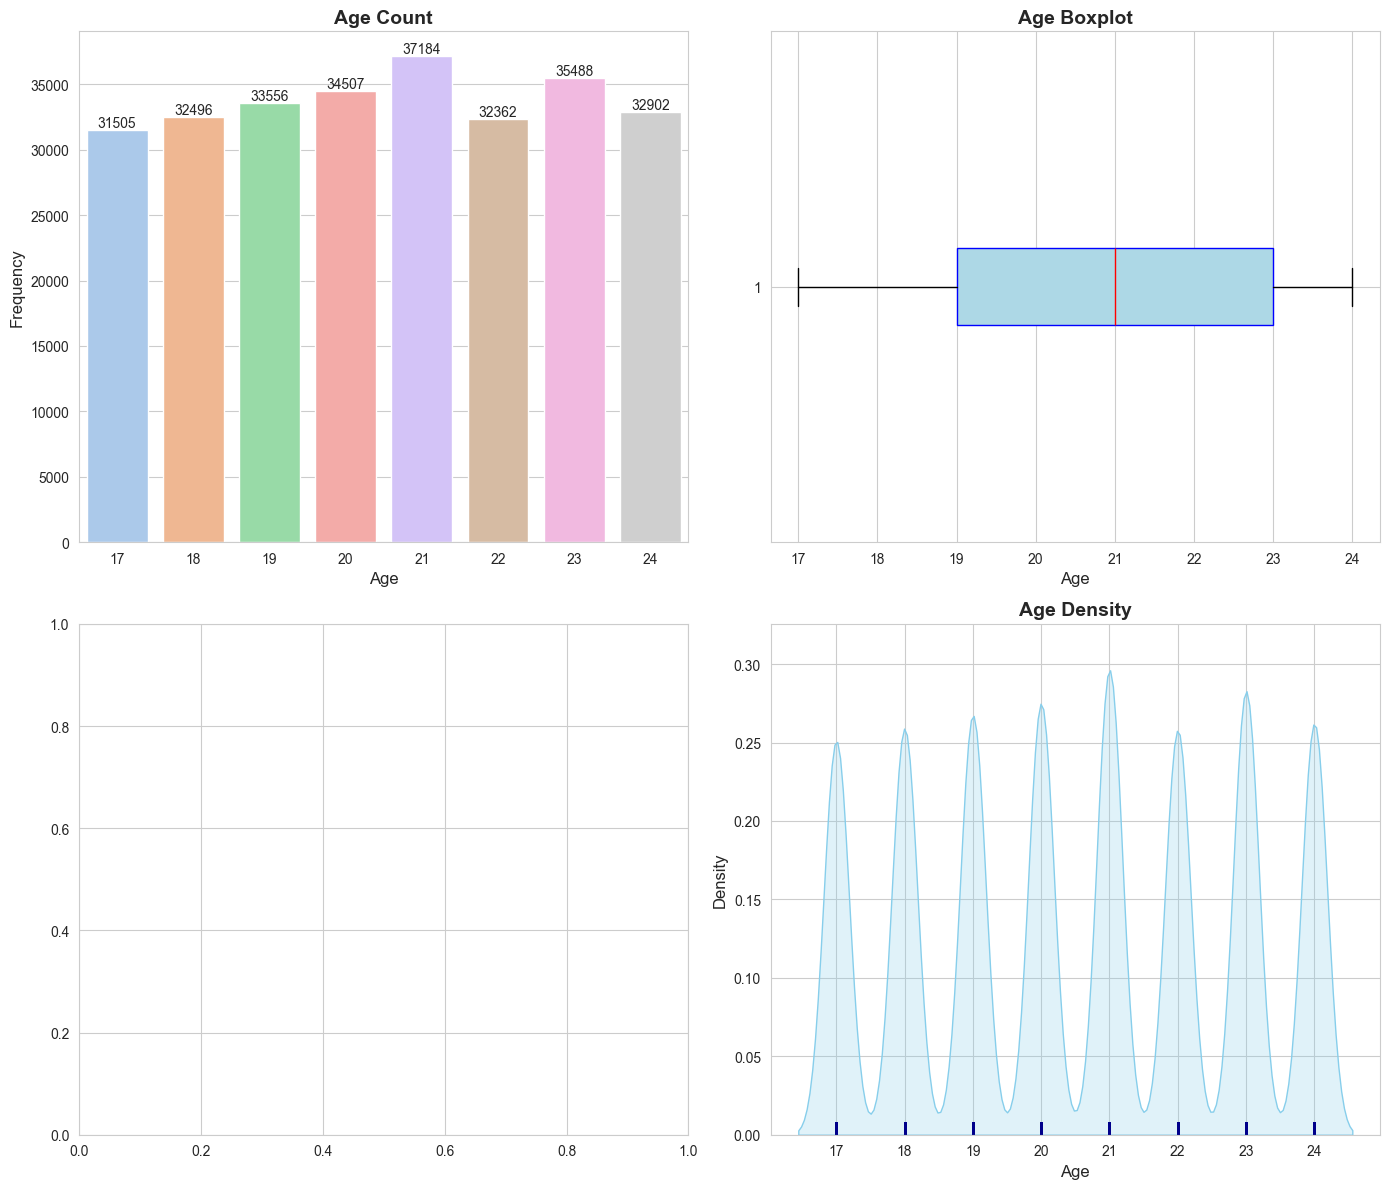

In [15]:
# Set style
sns.set_style("whitegrid")
palette = "pastel"

# Create 2x2 figure
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

# 1 Countplot: Age frequencies
sns.countplot(x="age", data=dataset_test, ax=ax[0], palette=palette)
ax[0].set_title("Age Count", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Age", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)

# Annotate counts
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}',  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)

# 2 Boxplot: Age summary
ax[1].boxplot(dataset_test["age"], vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue'),
              medianprops=dict(color='red'))
ax[1].set_xlabel("Age", fontsize=12)
ax[1].set_title("Age Boxplot", fontsize=14, fontweight='bold')

# 3 Hexbin: Age vs Exam Score
# hb = ax[2].hexbin(
#     dataset_test["age"],
#     dataset_test["exam_score"],
#     gridsize=25,
#     cmap="viridis",
#     edgecolors='grey'
# )
# cbar = plt.colorbar(hb, ax=ax[2])
# cbar.set_label("Count", fontsize=12)
# ax[2].set_xlabel("Age", fontsize=12)
# ax[2].set_ylabel("Exam Score", fontsize=12)
# ax[2].set_title("Age vs Exam Score", fontsize=14, fontweight='bold')

# 4 KDE: Age distribution
sns.kdeplot(dataset_test["age"], ax=ax[3], fill=True, color='skyblue')
sns.rugplot(dataset_test["age"], ax=ax[3], color='darkblue')
ax[3].set_xlabel("Age", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Age Density", fontsize=14, fontweight='bold')

# Layout adjustments
plt.tight_layout()
plt.show()
